In [ ]:
import string
import argparse as ap
import sys
import os


import obspy
import obspy.core as oc
from obspy import read_inventory
from obspy.core import UTCDateTime
from obspy import read
from tqdm import tqdm
# from datetime import datetime, timedelta
import time

import pylab as plt
import pandas as pd
import h5py

from pathlib import Path
import h5py
import numpy as np


import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec

import seaborn as sns

import datetime
import warnings

In [2]:
pathNow = Path().parent.absolute() #See @Arminius answer
pathNow = pathNow.parent
print(pathNow)


dataset_path = '/Muhammad Fadli/Dataset/'
data = sbd.InstanceGM(root = 'f://UNIVERSITAS INDONESIA//BMKG Research 2 - 2024.EEWS//Datasets//instancegm')

f:\UNIVERSITAS INDONESIA\BMKG Research 2 - 2024.EEWS


2025-05-11 21:26:18,138 | seisbench | WARNING | Output component order not specified, defaulting to 'ZNE'.


In [3]:
pd.set_option('display.max_columns', None)
data.metadata.head(10)

,index,source_id,station_network_code,station_code,station_location_code,station_channels,station_latitude_deg,station_longitude_deg,station_elevation_m,station_vs_30_mps,station_vs_30_detail,source_origin_time,source_latitude_deg,source_longitude_deg,source_depth_km,source_origin_uncertainty_s,source_latitude_uncertainty_deg,source_longitude_uncertainty_deg,source_depth_uncertainty_km,source_stderror_s,source_gap_deg,source_horizontal_uncertainty_km,source_magnitude,source_magnitude_type,source_mt_eval_mode,source_mt_status,source_mt_scalar_moment,source_mechanism_strike_dip_rake,source_mechanism_moment_tensor,path_travel_time_P_s,path_travel_time_S_s,path_residual_P_s,path_residual_S_s,path_ep_distance_km,path_hyp_distance_km,path_azimuth_deg,path_backazimuth_deg,path_weight_phase_location_P,path_weight_phase_location_S,trace_start_time,trace_dt_s,trace_npts,trace_eval_P,trace_P_uncertainty_s,trace_P_arrival_time,trace_polarity,trace_eval_S,trace_S_uncertainty_s,trace_S_arrival_time,trace_P_arrival_sample,trace_S_arrival_sample,trace_E_median_counts,trace_N_median_counts,trace_Z_median_counts,trace_E_mean_counts,trace_N_mean_counts,trace_Z_mean_counts,trace_E_min_counts,trace_N_min_counts,trace_Z_min_counts,trace_E_max_counts,trace_N_max_counts,trace_Z_max_counts,trace_E_rms_counts,trace_N_rms_counts,trace_Z_rms_counts,trace_E_lower_quartile_counts,trace_N_lower_quartile_counts,trace_Z_lower_quartile_counts,trace_E_upper_quartile_counts,trace_N_upper_quartile_counts,trace_Z_upper_quartile_counts,trace_E_spikes,trace_N_spikes,trace_Z_spikes,trace_E_snr_db,trace_N_snr_db,trace_Z_snr_db,trace_E_pga_cmps2,trace_E_pgv_cmps,trace_E_pga_perc,trace_E_pga_time,trace_E_pgv_time,trace_E_sa03_cmps2,trace_E_sa10_cmps2,trace_E_sa30_cmps2,trace_N_pga_cmps2,trace_N_pgv_cmps,trace_N_pga_perc,trace_N_pga_time,trace_N_pgv_time,trace_N_sa03_cmps2,trace_N_sa10_cmps2,trace_N_sa30_cmps2,trace_Z_pga_cmps2,trace_Z_pgv_cmps,trace_Z_pga_perc,trace_Z_pga_time,trace_Z_pgv_time,trace_Z_sa03_cmps2,trace_Z_sa10_cmps2,trace_Z_sa30_cmps2,trace_pga_cmps2,trace_pgv_cmps,trace_pga_perc,trace_sa03_cmps2,trace_sa10_cmps2,trace_sa30_cmps2,trace_name,trace_GPD_P_number,trace_GPD_S_number,trace_EQT_number_detections,trace_EQT_P_number,trace_EQT_S_number,trace_deconvolved_units,trace_name_original,split,trace_chunk,trace_sampling_rate_hz,trace_component_order
0,0,10000541,MN,AQU,NaN,HH,42.354000,13.405000,710.0,485.0,Vs30 extracted from ShakeMap,2016-11-16T01:35:56.21Z,42.7592,13.1932,10.3,0.03,0.0018,0.0024,0.2,0.19,44.0,0.24,2.1,ML,NaN,NaN,NaN,NaN,NaN,8.90,15.78,-0.06,0.29,48.255,49.342,158.8,338.9,94.0,45.0,2016-11-16T01:35:48.20Z,0.01,12000,manual,0.1,2016-11-16T01:36:05.11Z,undecidable,manual,0.6,2016-11-16T01:36:11.99Z,1691,2379.0,31.0,-18.0,-4.0,-0.04558,0.03583,0.01883,-983.0,-1206.0,-603.0,952.0,1188.0,510.0,210.944,232.536,106.850,-144.0,-159.0,-70.00,147.00,156.0,70.0,0.0,0.0,0.0,5.184,8.389,4.641,0.008466,0.000134,0.000863,2016-11-16T01:37:29.256593Z,2016-11-16T01:36:13.606593Z,0.000569,0.000071,0.000019,0.011791,0.000158,0.001202,2016-11-16T01:37:28.956593Z,2016-11-16T01:37:28.996593Z,0.000812,0.000060,0.000019,0.006395,0.000077,0.000652,2016-11-16T01:37:28.946593Z,2016-11-16T01:36:16.106593Z,0.000372,0.000057,0.000014,0.011791,0.000158,0.001202,0.000812,0.000071,0.000019,"bucket0$0,:3,:12000",1.0,1.0,1.0,1.0,1.0,mps,"bucket0$0,:3,:12000",train,,100.0,ZNE
1,1,10000541,MN,AQU,NaN,HL,42.354000,13.405000,710.0,485.0,Vs30 extracted from ShakeMap,2016-11-16T01:35:56.21Z,42.7592,13.1932,10.3,0.03,0.0018,0.0024,0.2,0.19,44.0,0.24,2.1,ML,NaN,NaN,NaN,NaN,NaN,8.90,15.78,-0.06,0.29,48.255,49.342,158.8,338.9,94.0,45.0,2016-11-16T01:35:47.56Z,0.01,12000,manual,0.1,2016-11-16T01:36:05.11Z,undecidable,manual,0.6,2016-11-16T01:36:11.99Z,1755,2443.0,0.0,0.0,0.0,-0.02458,0.01900,-0.04508,-55.0,-74.0,-51.0,63.0,76.0,53.0,6.208,6.372,5.070,-3.0,-3.0,-3.00,3.00,3.0,3.0,0.0,0.0,0.0,6.838,8.383,3.838,0.009292,0.000808,0.000948,2016-11-16T01:37:29.236593Z,2016-11-16T01:36:09.28

In [3]:
list_eve=['trace_E_min_counts','trace_N_min_counts','trace_Z_min_counts',
         'trace_E_max_counts','trace_N_max_counts','trace_Z_max_counts',
         'trace_E_median_counts','trace_N_median_counts','trace_Z_median_counts',
         'trace_E_mean_counts','trace_N_mean_counts','trace_Z_mean_counts',
         'trace_E_pga_perc','trace_N_pga_perc','trace_Z_pga_perc',
         'trace_E_pga_cmps2','trace_N_pga_cmps2','trace_Z_pga_cmps2',
         'trace_E_pgv_cmps','trace_N_pgv_cmps','trace_Z_pgv_cmps',
         'trace_E_snr_db','trace_N_snr_db','trace_Z_snr_db',
         'trace_E_sa03_cmps2','trace_N_sa03_cmps2','trace_Z_sa03_cmps2',
         'trace_pgv_cmps', 'trace_pga_perc',
         'trace_EQT_number_detections','trace_EQT_P_number','trace_EQT_S_number','trace_GPD_P_number','trace_GPD_S_number']

list_noise=['trace_E_max_counts','trace_EQT_number_detections','trace_GPD_P_number','trace_GPD_S_number']

In [4]:
for ele in list_eve:
    data.metadata[ele] =  pd.to_numeric(data.metadata[ele], errors='coerce')

In [5]:
# Filter PGA >= 1
mask_pga_high = (data.metadata["trace_pga_cmps2"] >= 1)

# Count the number of high-PGA events
num_pga_high = mask_pga_high.sum()

# Filter PGA < 1
mask_pga_low = (data.metadata["trace_pga_cmps2"] < 1)

# Randomly select quarter the number of high-PGA events from low-PGA ones
selected_low_pga_indices = np.random.choice(data.metadata[mask_pga_low].index, size=num_pga_high // 4, replace=False)

# Apply all filters
mask = (((data.metadata["trace_pga_cmps2"] >= 1) | (data.metadata.index.isin(selected_low_pga_indices))) & 
(data.metadata["path_ep_distance_km"] <= 247.3) & 
(data.metadata["path_ep_distance_km"] >= 1.5) &
(data.metadata["trace_pga_cmps2"] <= 500) &
(data.metadata["trace_deconvolved_units"] == "mps2") & 
(data.metadata["trace_pga_cmps2"].notna()) &
(data.metadata["trace_Z_snr_db"] >= 10) & 
(data.metadata["trace_E_snr_db"] >= 10) & 
(data.metadata["trace_N_snr_db"] >= 10) & 
(data.metadata["trace_pga_cmps2"]>=1) &
(data.metadata["source_depth_km"] <= 394))

data.filter(mask)


print(data)

InstanceGM - 16630 traces


In [6]:
all_streams = []

for idx, (index, example) in tqdm(enumerate(data.metadata.iterrows())):
    stream = obspy.Stream()
    waveform = data.get_waveforms(idx)

    for i in range(waveform.shape[0]):
        trace = obspy.Trace(data=waveform[i])
        trace.stats.station = example["station_code"]
        trace.stats.sampling_rate = example["trace_sampling_rate_hz"]
        trace.stats.starttime = UTCDateTime(example["trace_start_time"])
        trace.stats.channel = ["Z", "N", "E"][i] if i < 3 else f"CH{i+1}"
        stream.append(trace)
    all_streams.append(stream)

16630it [01:29, 185.75it/s]


In [ ]:
import gc
gc.collect()

0

In [44]:
data.metadata

,index,source_id,station_network_code,station_code,station_location_code,station_channels,station_latitude_deg,station_longitude_deg,station_elevation_m,station_vs_30_mps,station_vs_30_detail,source_origin_time,source_latitude_deg,source_longitude_deg,source_depth_km,source_origin_uncertainty_s,source_latitude_uncertainty_deg,source_longitude_uncertainty_deg,source_depth_uncertainty_km,source_stderror_s,source_gap_deg,source_horizontal_uncertainty_km,source_magnitude,source_magnitude_type,source_mt_eval_mode,source_mt_status,source_mt_scalar_moment,source_mechanism_strike_dip_rake,source_mechanism_moment_tensor,path_travel_time_P_s,path_travel_time_S_s,path_residual_P_s,path_residual_S_s,path_ep_distance_km,path_hyp_distance_km,path_azimuth_deg,path_backazimuth_deg,path_weight_phase_location_P,path_weight_phase_location_S,trace_start_time,trace_dt_s,trace_npts,trace_eval_P,trace_P_uncertainty_s,trace_P_arrival_time,trace_polarity,trace_eval_S,trace_S_uncertainty_s,trace_S_arrival_time,trace_P_arrival_sample,trace_S_arrival_sample,trace_E_median_counts,trace_N_median_counts,trace_Z_median_counts,trace_E_mean_counts,trace_N_mean_counts,trace_Z_mean_counts,trace_E_min_counts,trace_N_min_counts,trace_Z_min_counts,trace_E_max_counts,trace_N_max_counts,trace_Z_max_counts,trace_E_rms_counts,trace_N_rms_counts,trace_Z_rms_counts,trace_E_lower_quartile_counts,trace_N_lower_quartile_counts,trace_Z_lower_quartile_counts,trace_E_upper_quartile_counts,trace_N_upper_quartile_counts,trace_Z_upper_quartile_counts,trace_E_spikes,trace_N_spikes,trace_Z_spikes,trace_E_snr_db,trace_N_snr_db,trace_Z_snr_db,trace_E_pga_cmps2,trace_E_pgv_cmps,trace_E_pga_perc,trace_E_pga_time,trace_E_pgv_time,trace_E_sa03_cmps2,trace_E_sa10_cmps2,trace_E_sa30_cmps2,trace_N_pga_cmps2,trace_N_pgv_cmps,trace_N_pga_perc,trace_N_pga_time,trace_N_pgv_time,trace_N_sa03_cmps2,trace_N_sa10_cmps2,trace_N_sa30_cmps2,trace_Z_pga_cmps2,trace_Z_pgv_cmps,trace_Z_pga_perc,trace_Z_pga_time,trace_Z_pgv_time,trace_Z_sa03_cmps2,trace_Z_sa10_cmps2,trace_Z_sa30_cmps2,trace_pga_cmps2,trace_pgv_cmps,trace_pga_perc,trace_sa03_cmps2,trace_sa10_cmps2,trace_sa30_cmps2,trace_name,trace_GPD_P_number,trace_GPD_S_number,trace_EQT_number_detections,trace_EQT_P_number,trace_EQT_S_number,trace_deconvolved_units,trace_name_original,split,trace_chunk,trace_sampling_rate_hz,trace_component_order
20,20,10000541,IV,NRCA,NaN,HN,42.833550,13.114270,927.0,591.0,Vs30 measured on field,2016-11-16T01:35:56.21Z,42.7592,13.1932,10.30,0.03,0.0018,0.0024,0.2,0.1900,44.0,0.24,2.1,ML,NaN,NaN,NaN,NaN,NaN,3.08,4.78,0.13,-0.32,10.484,14.697,322.0,142.0,100.00,72.00,2016-11-16T01:35:39.43Z,0.01,12000,manual,0.1,2016-11-16T01:35:59.29Z,positive,manual,0.3,2016-11-16T01:36:00.99Z,1986,2156.0,0.0,0.0,0.0,0.00167,-0.00750,-0.00233,-3751.0,-3184.0,-2975.0,3696.0,3324.0,2870.0,158.306,151.648,141.624,-14.00,-13.00,-4.00,14.00,13.00,4.00,0.0,0.0,1.0,35.168,35.268,41.085,1.187613,0.014381,0.121103,2016-11-16T01:36:01.550200Z,2016-11-16T01:36:01.160200Z,0.020432,0.001097,0.000141,1.067454,0.009709,0.108850,2016-11-16T01:36:01.520000Z,2016-11-16T01:36:01.500000Z,0.012258,0.001331,0.000126,1.041614,0.009095,0.106215,2016-11-16T01:35:59.310000Z,2016-11-16T01:35:59.320000Z,0.006676,0.000585,0.000092,1.187613,0.014381,0.121103,0.020432,0.001331,0.000141,"bucket0$20,:3,:12000",NaN,NaN,NaN,NaN,NaN,mps2,"bucket0$20,:3,:12000",train,,100.0,ZNE
74,74,10000641,IV,FEMA,NaN,HN,42.962100,13.049760,1370.0,609.0,Vs30 extracted from ShakeMap,2016-11-16T01:39:14.75Z,42.8823,13.1667,7.60,0.03,0.0018,0.0037,0.2,0.2200,56.0,0.25,3.0,ML,NaN,NaN,NaN,NaN,NaN,3.21,5.35,0.20,0.14,13.029,15.083,312.9,132.8,96.00,49.00,2016-11-16T01:39:00.41Z,0.01,12000,manual,0.1,2016-11-16T01:39:17.96Z,positive,manual,0.6,2016-11-16T01:39:20.10Z,1755,1969.0,0.0,0.0,0.0,-0.00125,0.00425,0.00642,-4764.0,-6195.0,-3703.0,4844.0,4842.0,2959.0,257.337,217.967,164.754,-6.00,-8.00,-5.00,6.00,8.00,5.00,0.0,0.0,0.0,48.239,44.324,44.251,1.448342,0.022512,0.147690,2016-11-16T01:39:21

In [26]:
waveform_index =  1023

In [25]:
all_streams[waveform_index][1].data.shape[0]

12000

In [11]:
start_time = all_streams[waveform_index][0].stats.starttime
p_arrival_time = data.metadata['trace_P_arrival_time'].iloc[waveform_index]
p_arrival_time_utc = UTCDateTime(p_arrival_time)

fig = plt.figure(figsize=(8,8))
all_streams[waveform_index].plot(fig=fig)

# Axis of the plot
for ax in fig.axes:
    ax.axvline(date2num(p_arrival_time_utc), color='r', lw=2, label='P Arrival')
    ax.axvline(date2num(p_arrival_time_utc + 3), color='b', lw=2, label='P3s')
    ax.set_ylabel('Acceleration (m/s²)')
    ax.legend()


plt.show()

NameError: name 'waveform_index' is not defined

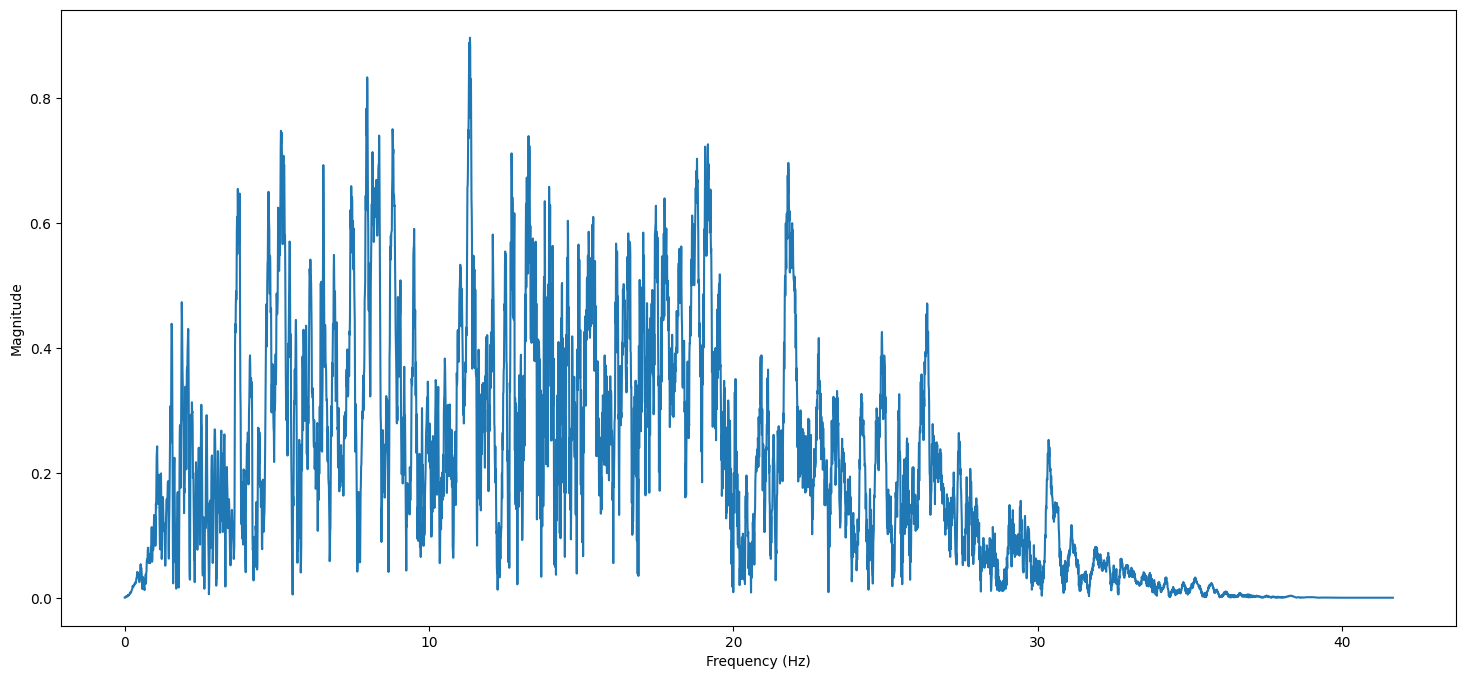

In [51]:
import scipy as sp

sr = 100

ft = sp.fft.fft(all_streams[waveform_index][0])
magnitude = np.absolute(ft)
frequency = np.linspace(0, sr, len(magnitude))

# plot spectrum
plt.figure(figsize=(18,8))
plt.plot(frequency[:5000], magnitude[:5000])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

# === Parameters ===
waveform = all_streams[waveform_index]
sampling_rate = waveform[0].stats.sampling_rate  # assuming all 3 channels have same sampling rate
channel_labels = ['Z', 'N', 'E']

# === Processing & Plotting ===
for i, label in enumerate(channel_labels):
    data = waveform[i].data.astype(np.float32)  # ensure float for librosa

    # === 1. FFT ===
    fft_spectrum = np.fft.fft(data)
    freq = np.fft.fftfreq(len(data), d=1/sampling_rate)
    magnitude = np.abs(fft_spectrum)

    # Only take the positive frequencies
    idx = np.where(freq >= 0)
    freq = freq[idx]
    magnitude = magnitude[idx]

    # Plot FFT
    plt.figure(figsize=(10, 4))
    plt.plot(freq, magnitude)
    plt.title(f'FFT - Channel {label}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === 2. Mel Spectrogram ===
    mel_spec = librosa.feature.melspectrogram(y=data, sr=sampling_rate, n_fft=2048, hop_length=512, n_mels=128)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    # Plot Mel Spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spec_db, sr=sampling_rate, hop_length=512, x_axis='time', y_axis='mel')
    plt.title(f'Mel Spectrogram - Channel {label}')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

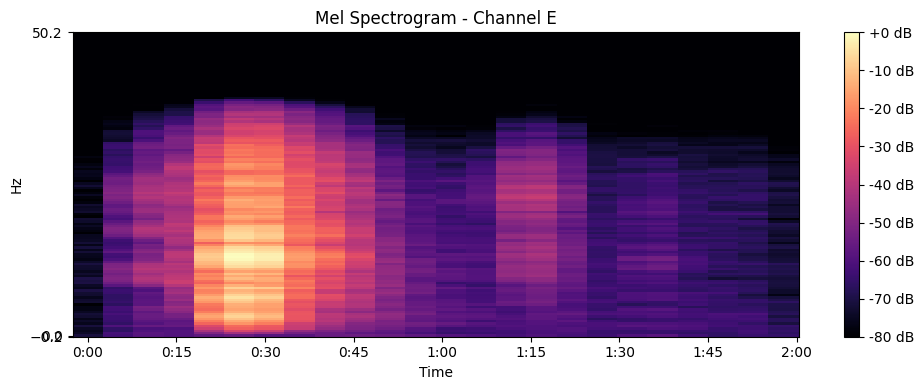

In [14]:
import im_calculation as imc

# === Parameters ===
waveform = all_streams[waveform_index]
sampling_rate = waveform[0].stats.sampling_rate  # assuming all 3 channels have same sampling rate

best_trace = imc.best_trace_checker(all_streams, waveform_index)  
# === 2. Mel Spectrogram ===
mel_spec = librosa.feature.melspectrogram(y=data, sr=sampling_rate, n_fft=2048, hop_length=512, n_mels=128)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)


# Plot Mel Spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spec_db, sr=sampling_rate, hop_length=512, x_axis='time', y_axis='mel')
plt.title(f'Mel Spectrogram - Channel {label}')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()


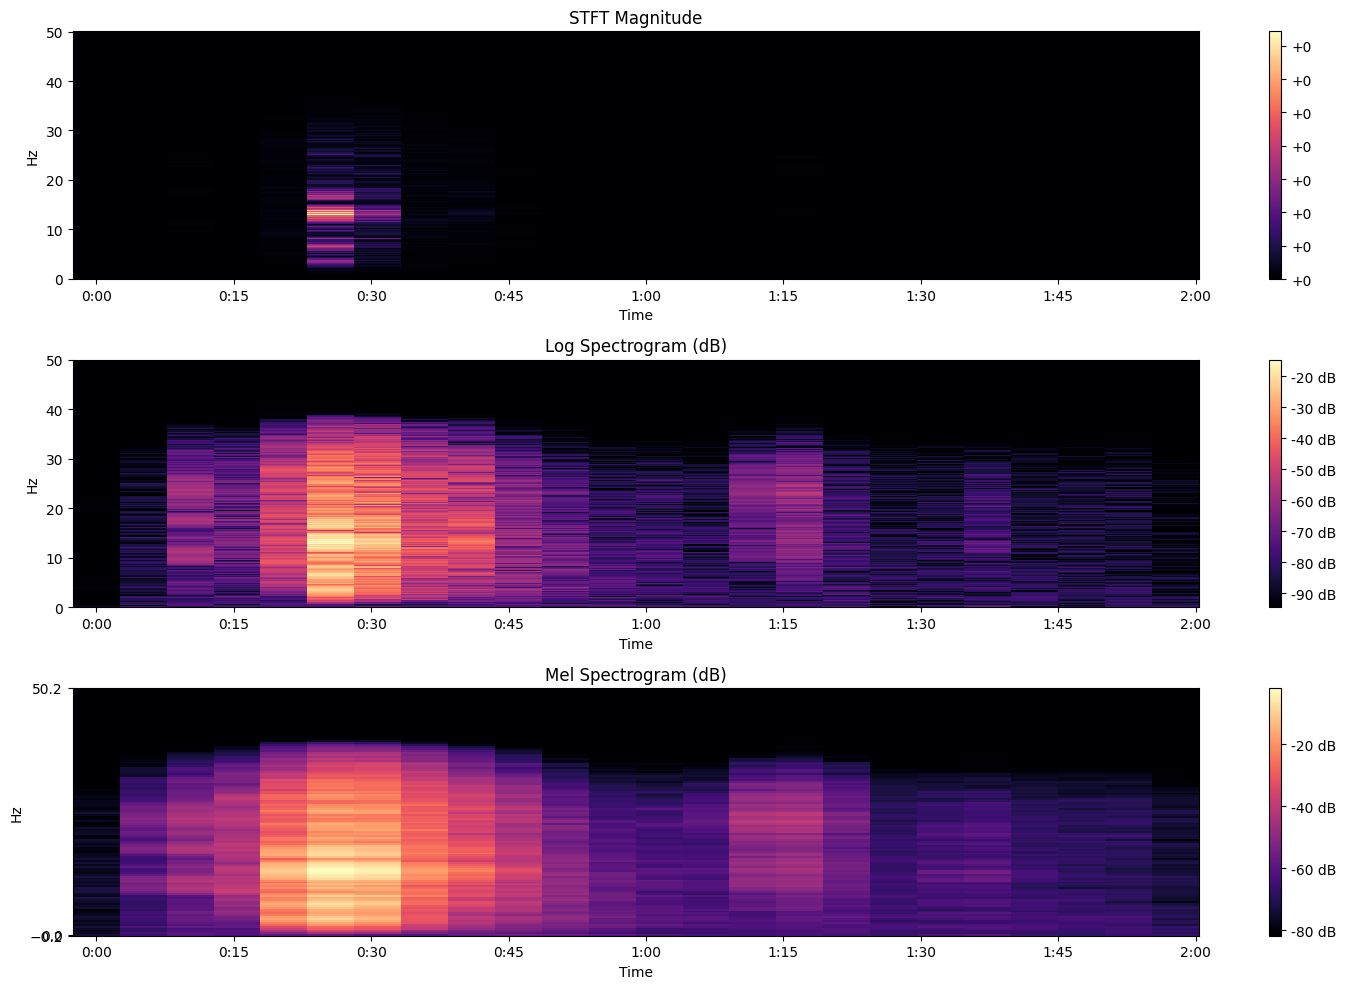

In [ ]:
# Extract the waveform data
waveform = all_streams[waveform_index]
data = waveform[1].data.astype(np.float32)
sr = waveform[1].stats.sampling_rate

# Compute STFT and spectrogram
stft = librosa.stft(data, n_fft=1024, hop_length=512)
spectrogram = np.abs(stft)
log_spectrogram = librosa.amplitude_to_db(spectrogram)

# Compute Mel spectrogram and convert to dB
mel_spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)

#-------------- Plotting--------------------
plt.figure(figsize=(15, 10))

# STFT Magnitude
plt.subplot(3, 1, 1)
librosa.display.specshow(spectrogram, sr=sr, hop_length=512, x_axis='time', y_axis='linear')
plt.title('STFT Magnitude')
plt.colorbar(format='%+2.0f')

# Log Spectrogram
plt.subplot(3, 1, 2)
librosa.display.specshow(log_spectrogram, sr=sr, hop_length=512, x_axis='time', y_axis='linear')
plt.title('Log Spectrogram (dB)')
plt.colorbar(format='%+2.0f dB')

# Mel Spectrogram (Log Scale)
plt.subplot(3, 1, 3)
librosa.display.specshow(log_mel_spectrogram, sr=sr, hop_length=512, x_axis='time', y_axis='mel')
plt.title('Mel Spectrogram (dB)')
plt.colorbar(format='%+2.0f dB')

plt.tight_layout()
plt.show()

In [ ]:
# Turn off interactive mode
plt.ioff()

# Directory to save images
save_dir = "mel_spectrograms"
os.makedirs(save_dir, exist_ok=True)

waveform = all_streams[waveform_index]
sampling_rate = waveform[0].stats.sampling_rate
channel_labels = ['Z', 'N', 'E']

for i, label in enumerate(channel_labels):
    data = waveform[i].data.astype(np.float32)

    # Compute mel spectrogram
    mel_spec = librosa.feature.melspectrogram(y=data, sr=sampling_rate, n_fft=2048, hop_length=512, n_mels=128)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    # Plot without axes and borders
    fig = plt.figure(figsize=(3, 3), dpi=100)  # Adjust size/dpi as needed
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    librosa.display.specshow(mel_spec_db, sr=sampling_rate, hop_length=512, y_axis='mel', x_axis='time', cmap='magma')

    # Save to PNG
    save_path = os.path.join(save_dir, f"waveform{waveform_index}_channel{label}.png")
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close(fig)

In [56]:
log_mel_spectrogram.shape

(128, 24)

In [8]:
# type:ignore
import numpy as np
from tqdm import tqdm

M_S2_TO_G      = 9.80665  # Conversion factor: 1 g = 9.80665 m/s²
sampling_rate   = 100
damping_ratio   = 0.05
min_period      = 0.01
max_period      = 5.0
num_periods     = 50

def calc_sdf_resp(freq, fourier_amp, osc_damping, osc_freq, max_freq_ratio=5., peak_resp_only=False):
    h = (-np.power(osc_freq, 2.) / ((np.power(freq, 2.) - np.power(osc_freq, 2.)) - 2.j * osc_damping * osc_freq * freq))
    n = len(fourier_amp)
    m = max(n, int(max_freq_ratio * osc_freq / freq[1]))
    scale = float(m) / float(n)
    resp = scale * np.fft.irfft(fourier_amp * h, 2 * (m - 1))
    if peak_resp_only:
        return np.abs(resp).max()
    return resp

def calc_spec_accels(time_step, accel_ts, osc_freqs, osc_damping=0.05):
    fourier_amp = np.fft.rfft(accel_ts)
    freq = np.linspace(0, 1. / (2 * time_step), num=fourier_amp.size)
    spec_accels = [calc_sdf_resp(freq, fourier_amp, osc_damping, of, peak_resp_only=True)
                   for of in osc_freqs]
    return np.rec.fromarrays([osc_freqs, spec_accels], names='osc_freq,spec_accel')

def load_acceleration_file(filepath):
    acc_data_in_cm_s2 = np.loadtxt(filepath)
    return acc_data_in_m_s2 / M_S2_TO_G  # Convert from m/s² to g

def compute_pgv(acc, time_step):
    vel = np.cumsum(acc) * time_step
    return np.max(np.abs(vel))

def compute_pgd(vel, time_step):
    disp = np.cumsum(vel) * time_step
    return np.max(np.abs(disp))

def gen_rsa(file_to_use, figures_dir):
    data = load_acceleration_file(file_to_use)
    osc_damping = damping_ratio
    osc_freqs = np.logspace(np.log10(1.0 / max_period), np.log10(1.0 / min_period), num_periods)
    time_step = 1.0 / sampling_rate

    pga = np.max(np.abs(data))
    pgv = compute_pgv(data, time_step)
    pgd = compute_pgd(pgv, time_step)

    resp_spec = calc_spec_accels(time_step, data, osc_freqs, osc_damping)



In [10]:
import h5py
import os
import gc
import numpy as np
import librosa
from tqdm import tqdm
import matplotlib.pyplot as plt
from obspy import UTCDateTime
import io
from PIL import Image
import im_calculation as imc
import matplotlib

matplotlib.use('Agg')

# === Setup paths ===
base_folder = os.path.join(str(pathNow), 'Muhammad Fadli')
hdf5_folder = os.path.join(base_folder, 'spectral_data')
images_folder = os.path.join(base_folder, 'mel_spectrograms')

# Create directories
os.makedirs(hdf5_folder, exist_ok=True)
os.makedirs(images_folder, exist_ok=True)
os.makedirs(os.path.join(images_folder, 'trimmed_3s'), exist_ok=True)
os.makedirs(os.path.join(images_folder, 'trimmed_25s'), exist_ok=True)
os.makedirs(os.path.join(images_folder, 'trimmed_2s'), exist_ok=True)
os.makedirs(os.path.join(images_folder, 'full'), exist_ok=True)

hdf5_path = os.path.join(hdf5_folder, 'log_final_response_dataset_50periods.h5')

# Calculate periods only once
osc_freqs = np.logspace(np.log10(1.0 / max_period), np.log10(1.0 / min_period), num_periods)
osc_periods = 1.0 / osc_freqs
time_step = 1.0 / sampling_rate

# Function to save mel spectrogram as PNG image
def save_mel_spectrogram_as_png(mel_spec_db, file_path, vmin=-80, vmax=0):
    plt.figure(figsize=(10, 4), dpi=200)  # Lower DPI for faster processing
    plt.axis('off')
    img = librosa.display.specshow(
        mel_spec_db, 
        x_axis='off',
        y_axis='off',
        vmin=vmin,
        vmax=vmax,
        cmap='viridis'
    )
    plt.tight_layout()
    plt.savefig(file_path, bbox_inches='tight', pad_inches=0)
    plt.close()
    gc.collect()

# Initialize HDF5 file and create root datasets
with h5py.File(hdf5_path, 'w') as hdf5_file:
    # Save periods once
    hdf5_file.create_dataset('osc_periods', data=osc_periods)
    
    # Process in batches to save memory
    batch_size = 1  # Adjust based on your system's memory capacity
    total_streams = len(all_streams)
    
    # Create a metadata dataset to link images to HDF5 data
    dt = np.dtype([
        ('event_id', 'S10'), 
        ('trimmed_3s_mel_path', 'S100'),
        ('trimmed_25s_mel_path', 'S100'),
        ('trimmed_2s_mel_path', 'S100'),
        ('full_mel_path', 'S100')
    ])
    
    # Create image metadata dataset
    image_metadata_dset = hdf5_file.create_dataset('image_metadata', (total_streams,), dtype=dt)
    
    # Process in batches
    for batch_start in tqdm(range(0, total_streams, batch_size), desc="Processing batches"):
        batch_end = min(batch_start + batch_size, total_streams)
        
        for i in range(batch_start, batch_end):
            event_id = f"event_{i:04d}"
            
            # Get original stream (don't keep copies of all streams)
            stream = all_streams[i]
            
            # Create trimmed streams on-the-fly (don't store in arrays)
            trimmed_stream_3s = stream.copy()
            trimmed_stream_25s = stream.copy()
            trimmed_stream_2s = stream.copy()
            
            p_arrival_time = UTCDateTime(data.metadata["trace_P_arrival_time"].iloc[i])
            
            for j in range(len(stream)):
                trimmed_stream_3s[j].trim(starttime=p_arrival_time, endtime=p_arrival_time + 3)
                trimmed_stream_25s[j].trim(starttime=p_arrival_time, endtime=p_arrival_time + 2.5)
                trimmed_stream_2s[j].trim(starttime=p_arrival_time, endtime=p_arrival_time + 2)
            
            # Select best traces
            best_trace_full = imc.best_trace_checker([stream], 0)
            best_trace_index = None
            for k, trace in enumerate(stream):
                if trace.id == best_trace_full.id:
                    best_trace_index = k
                    break

            best_trace_3s = trimmed_stream_3s[best_trace_index]
            best_trace_25s = trimmed_stream_25s[best_trace_index]
            best_trace_2s = trimmed_stream_2s[best_trace_index]
            
            # Compute acceleration spectra from FULL waveform
            data_in_g = best_trace_full.data / M_S2_TO_G
            resp_spec = calc_spec_accels(time_step, data_in_g, osc_freqs, damping_ratio)
            spec_accel = np.log(resp_spec.spec_accel)
            
            # Calculate Mel Spectrograms with optimized parameters
            # For trimmed traces - use appropriate parameters for each duration
            # 3s trace
            trimmed_data_3s = best_trace_3s.data
            trimmed_sr = best_trace_3s.stats.sampling_rate
            trimmed_mel_spec_3s = librosa.feature.melspectrogram(
                y=trimmed_data_3s, sr=trimmed_sr, n_fft=64, hop_length=16, n_mels=8
            )
            trimmed_mel_spec_db_3s = librosa.power_to_db(trimmed_mel_spec_3s, ref=np.max)
            
            # 2.5s trace
            trimmed_data_25s = best_trace_25s.data
            trimmed_mel_spec_25s = librosa.feature.melspectrogram(
                y=trimmed_data_25s, sr=trimmed_sr, n_fft=64, hop_length=16, n_mels=8
            )
            trimmed_mel_spec_db_25s = librosa.power_to_db(trimmed_mel_spec_25s, ref=np.max)
            
            # 2s trace
            trimmed_data_2s = best_trace_2s.data
            trimmed_mel_spec_2s = librosa.feature.melspectrogram(
                y=trimmed_data_2s, sr=trimmed_sr, n_fft=64, hop_length=16, n_mels=8
            )
            trimmed_mel_spec_db_2s = librosa.power_to_db(trimmed_mel_spec_2s, ref=np.max)
            
            # For full trace
            full_data = best_trace_full.data
            full_sr = best_trace_full.stats.sampling_rate
            full_mel_spec = librosa.feature.melspectrogram(
                y=full_data, sr=full_sr, n_fft=2048, hop_length=512, n_mels=128
            )
            full_mel_spec_db = librosa.power_to_db(full_mel_spec, ref=np.max)
            
            # Save Mel Spectrograms as PNG images in their respective folders
            trimmed_3s_img_path = os.path.join(images_folder, 'trimmed_3s', f"{event_id}.png")
            trimmed_25s_img_path = os.path.join(images_folder, 'trimmed_25s', f"{event_id}.png")
            trimmed_2s_img_path = os.path.join(images_folder, 'trimmed_2s', f"{event_id}.png")
            full_img_path = os.path.join(images_folder, 'full', f"{event_id}.png")
            
            save_mel_spectrogram_as_png(trimmed_mel_spec_db_3s, trimmed_3s_img_path)
            save_mel_spectrogram_as_png(trimmed_mel_spec_db_25s, trimmed_25s_img_path)
            save_mel_spectrogram_as_png(trimmed_mel_spec_db_2s, trimmed_2s_img_path)
            save_mel_spectrogram_as_png(full_mel_spec_db, full_img_path)
            
            # Store image paths in metadata
            image_metadata_dset[i] = (
                event_id.encode('utf-8'),
                trimmed_3s_img_path.encode('utf-8'),
                trimmed_25s_img_path.encode('utf-8'),
                trimmed_2s_img_path.encode('utf-8'),
                full_img_path.encode('utf-8')
            )
            
            # Compute metadata (using 3s trace as before)
            unit_type = imc.check_unit_type(data.metadata, i)
            Vs30 = imc.compute_vs30(data.metadata, i)
            Z25 = imc.compute_z25(data.metadata, i)
            PGA3s, PGV3s, PGD3s = imc.compute_peak_ground_motion(best_trace_3s, unit_type)
            PGA = (data.metadata["trace_pga_cmps2"].iloc[i]/100)/M_S2_TO_G
            Ia = imc.compute_arias_intensity(best_trace_3s, unit_type)
            CAV = imc.compute_cav(best_trace_3s, unit_type)
            Tm = imc.compute_predominant_period(best_trace_3s, unit_type)
            D5_95 = imc.compute_significant_duration(best_trace_3s, Ia, unit_type)
            
            # Get metadata values from original dataset
            mag_data = data.metadata["source_magnitude"].iloc[i]
            mag_type = data.metadata["source_magnitude_type"].iloc[i]
            stat_data = data.metadata["station_code"].iloc[i]
            epic_data = data.metadata["path_ep_distance_km"].iloc[i]
            depth_data = data.metadata["source_depth_km"].iloc[i]
            
            metadata_dict = {
                "Station": stat_data,
                "Vs30 (m/s)": Vs30,
                "Z2.5 (m)": Z25,
                "Ia (m/s)": Ia,
                "CAV (m/s)": CAV,
                "PGA (m/s2)": PGA,
                "PGA_3s (m/s2)": PGA3s,
                "PGV_3s (m/s)": PGV3s,
                "PGD_3s (m)": PGD3s,
                "Tm (s)": Tm,
                "D5-95 (s)": D5_95,
                "Magnitude": mag_data,
                "Magnitude_type": mag_type,
                "Epicenter (km)": epic_data,
                "Depth (km)": depth_data
            }
            
            # Save everything to HDF5
            grp_name = event_id
            grp = hdf5_file.create_group(grp_name)
            
            # Save all traces (use float32 to save memory)
            grp.create_dataset('full_trace', data=best_trace_full.data.astype(np.float32))
            grp.create_dataset('trimmed_trace_3s', data=best_trace_3s.data.astype(np.float32))
            grp.create_dataset('trimmed_trace_25s', data=best_trace_25s.data.astype(np.float32))
            grp.create_dataset('trimmed_trace_2s', data=best_trace_2s.data.astype(np.float32))
            
            # Save time reference information
            grp.attrs['full_trace_starttime'] = best_trace_full.stats.starttime.timestamp
            grp.attrs['sampling_rate'] = best_trace_full.stats.sampling_rate
            
            # Save spectral data (which is still calculated from the full waveform)
            spec_grp = grp.create_group('response_spectra')
            spec_grp.create_dataset('spec_accel', data=spec_accel.astype(np.float32))
            
            # Save mel spectrogram data (use float32 to save memory)
            mel_grp = grp.create_group('mel_spectrograms')
            mel_grp.create_dataset('trimmed_3s', data=trimmed_mel_spec_db_3s.astype(np.float32))
            mel_grp.create_dataset('trimmed_25s', data=trimmed_mel_spec_db_25s.astype(np.float32))
            mel_grp.create_dataset('trimmed_2s', data=trimmed_mel_spec_db_2s.astype(np.float32))
            mel_grp.create_dataset('full', data=full_mel_spec_db.astype(np.float32))
            
            # Store image paths as attributes
            grp.attrs['trimmed_3s_mel_image'] = trimmed_3s_img_path
            grp.attrs['trimmed_25s_mel_image'] = trimmed_25s_img_path
            grp.attrs['trimmed_2s_mel_image'] = trimmed_2s_img_path
            grp.attrs['full_mel_image'] = full_img_path
            
            # Save event metadata
            meta_grp = grp.create_group('metadata')
            for key, val in metadata_dict.items():
                meta_grp.attrs[key] = val
            
            # Explicitly delete variables to free memory
            del trimmed_stream_3s, trimmed_stream_25s, trimmed_stream_2s
            del best_trace_3s, best_trace_25s, best_trace_2s, best_trace_full
            del trimmed_mel_spec_3s, trimmed_mel_spec_db_3s
            del trimmed_mel_spec_25s, trimmed_mel_spec_db_25s
            del trimmed_mel_spec_2s, trimmed_mel_spec_db_2s
            del full_mel_spec, full_mel_spec_db
            
        # Force garbage collection after each batch
        gc.collect()

print("All data saved to HDF5 file with multiple trimmed waveforms and mel spectrograms saved as PNG images.")

Processing batches: 100%|██████████| 16630/16630 [9:50:47<00:00,  2.13s/it]  

All data saved to HDF5 file with multiple trimmed waveforms and mel spectrograms saved as PNG images.
